# 1. Introduction 

A brief description of your approach to the problem and the results that you have obtained on the training data.

<font color="red"><b>!!!!!!!! FILL THIS IN PLS<b>

# 2. Importing Libraries

This section is how you import the data into the notebook. It should be written in such a way that I can modify it to run on my own machine by simply changing the location of the training data and any additional data sources that you have used.


In [172]:
import numpy as np
import pandas as pd
import pandas_profiling
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import fbeta_score,accuracy_score 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)
%matplotlib inline

import visuals as vs


# Data dictionary
Below is a data dictionary from https://www.kaggle.com/yapsoonchung/eda-on-default-of-credit-card-clients-dataset/comments

# 3. Data Transformation and EDA

Any transformations that you apply to the data prior to training. Also, any exploration of the data that you performed such as visualization, feature selection, etc.


### Load the datasets

In [3]:
df_train = pd.read_csv("DataFiles/CreditCard_train.csv",header = 1)
df_test = pd.read_csv("DataFiles/CreditCard_test.csv",header = 1)
all_data = pd.concat([df_train,df_test])

In [4]:
#check data types, features, null values
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 5999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                

In [ ]:
general_stats= all_data.describe().iloc[:,0:6]
pay_status_stats = all_data.describe().iloc[:,6:12]
bill_stats = all_data.describe().iloc[:,12:18]
payed_stats = all_data.describe().iloc[:,18:24]

In [ ]:
general_stats

In [ ]:
pay_status_stats

In [ ]:
bill_stats

In [ ]:
payed_stats

In [ ]:
pandas_profiling.ProfileReport(all_data)

In [ ]:
# all_data.iplot()

<font color="red"> ------------Please elaborate on following graphs

In [ ]:
for c in all_data.columns[2:12]:
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(x = c, hue="default payment next month", data = all_data)

Because the the encoding for payment status ranged from -2 to infinitive, and the less is the better. We can add up all the payment status and use the sum to plot a graph. We can divide the data into two groups which are "ltz": less than zero and "mtz":more than zero, and investigate the percentage of getting default next month in each group.

In [ ]:
all_data["cumsum"] = all_data["PAY_0"] + all_data["PAY_2"] + all_data["PAY_3"] + all_data["PAY_4"] + all_data["PAY_5"] + all_data["PAY_6"]

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x = "cumsum", hue="default payment next month", data = all_data)

In [ ]:
ltz = all_data[all_data["cumsum"]<=0]
mtz = all_data[all_data["cumsum"]>0]

In [ ]:
ltz = all_data[all_data["cumsum"]<=0]
mtz = all_data[all_data["cumsum"]>0]
ltz_1 = ltz["default payment next month"][ltz["default payment next month"]==1].count()/len(ltz)
mtz_1 = mtz["default payment next month"][mtz["default payment next month"]==1].count()/len(mtz)
ltz_1, mtz_1

From the above results, we can see that only 13.8% of the "ltz" group will get a default of 1, while 48.7% the "mtz" group will get a default of 1.

In [ ]:
bills = ['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
for c in bills:
    fig, ax = plt.subplots(figsize=(10,6))
    n, bins, patches = plt.hist(x=all_data[c], bins='auto', color='#0504aa', rwidth=0.85)
    

From the above diagram, we can see that the data is highly skewed, transformation is necessary  before trainning so that the data do not negatively affect the performance of a learning algorithm. Later I will be using a logarithmic transformation significantly to reduce the range of values caused by outliers.

# 4. Data Cleaning

In [5]:
def clean(data):
    
    data = data.rename(columns={"PAY_0": "PAY_1"}) #rename the feature PAY_0 to keep the names consistent
    
    sex = {2:0} #0:female,1:male
    data["SEX"] = data["SEX"].replace(sex)
    
    data["EDUCATION"].replace([0,5,6], 4, inplace = True)
    data["MARRIAGE"].replace([0], 3, inplace = True)
    
    Y = data['default payment next month']
    data.drop('default payment next month', axis = 1,inplace = True)
    data.drop('ID', axis = 1,inplace = True)
    train = data
    
    #Normalise the range
    bills = ['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    
    features_cubic_transformed = train
    features_cubic_transformed[bills] = train[bills].apply(lambda x: np.sign(x) * np.power(abs(x), 1./3))
    
    # scale all numerical data
    numerical = ['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    
    scaler = MinMaxScaler()
    features_cubic_transformed[numerical] = scaler.fit_transform(features_cubic_transformed[numerical])
    
    final = pd.get_dummies(features_cubic_transformed, columns = ["EDUCATION","MARRIAGE"])
    
    return final,Y

In [6]:
# for c in bills:
#     fig, ax = plt.subplots(figsize=(10,6))
#     n, bins, patches = plt.hist(x=features_cubic_transformed[c], bins='auto', color='#0504aa', rwidth=0.85)

In [7]:
X,Y = clean(all_data)

In [9]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
train_x, test_x, train_y, test_y= train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 41)

# Show the results of the split
print("Training set has {} samples.".format(train_x.shape[0]))
print("Testing set has {} samples.".format(test_x.shape[0]))

Training set has 24000 samples.
Testing set has 6000 samples.


Investigate the effect on the accuracy when using different scaler

In [10]:
otrain_y = df_train['default payment next month']
df_train.drop('default payment next month', axis = 1,inplace = True)
df_train.drop('ID', axis = 1,inplace = True)
otrain_x = df_train
otest_y = df_test['default payment next month']
df_test.drop('default payment next month', axis = 1,inplace = True)
df_test.drop('ID', axis = 1,inplace = True)
otest_x = df_test

In [83]:
first = []
second = []
for n in range(1,60,5):
    clf1 = AdaBoostClassifier(random_state=41,n_estimators = n)
    clf1.fit(train_x,train_y)
    accuracy1 = clf1.score(test_x,test_y)
    first.append(accuracy1)
    
    
    clf2 = AdaBoostClassifier(random_state=41,n_estimators = n)
    clf2.fit(otrain_x,otrain_y)
    accuracy2 = clf2.score(otest_x,otest_y)
    second.append(accuracy2)
    
first.append(max(first))
second.append(max(second))
    
accuracy_table = pd.DataFrame([first, second], columns = range(1,65,5))    
    
accuracy_table         

,1,6,11,16,21,26,31,36,41,46,51,56,61
0,0.822333,0.817833,0.818167,0.818667,0.8170,0.815500,0.816000,0.817000,0.817500,0.817167,0.817667,0.819333,0.822333
1,0.830667,0.828167,0.825667,0.825833,0.8265,0.827167,0.826333,0.827167,0.826833,0.827833,0.827167,0.827667,0.830667


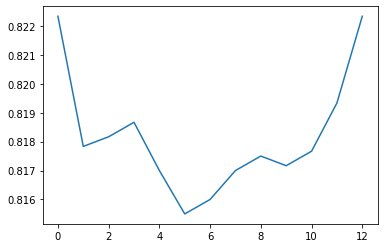

In [84]:
plt.plot(first)

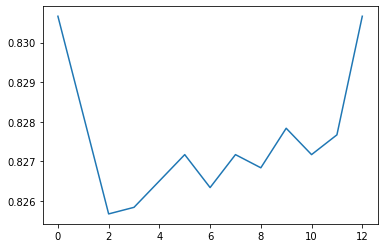

In [85]:
plt.plot(second)

In [87]:
importances = clf2.feature_importances_
import_list = importances.tolist()
df= pd.DataFrame(import_list, index = otrain_x.columns)
df.columns = ["clf2"]
df= pd.DataFrame(import_list, index = otrain_x.columns)
df.columns = ["clf2"]

# 5. Methodology Overview

Start by describing in broad terms your methodology. Include any background reading you may have done and a step by step description of how you have trained and evaluated your model. Describe any feature engineering that you have applied. If you had attempted different approaches prior to landing on your final methodology, then describe those approaches here.


### Model Selection

In [19]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    results = {}
    
    # Fit the learner
    start = time() # Get start time
    learner.fit(X_train, y_train)
    end = time() # Get end time
    # Calculate the training time
    results['train_time'] = end-start

    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    results['pred_time'] = end-start
    results['acc_train'] = accuracy_score(y_train,predictions_train)
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    results['f_train'] = fbeta_score(y_train,predictions_train,beta = 0.5)
    results['f_test'] = fbeta_score(y_test,predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__))
        
    # Return the results
    return results

In [24]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
tt = []
atr = []
ftr = []
pt = []
at = []
ft = []

# Initialize the models
clf_A = AdaBoostClassifier(random_state = 42)
clf_B = SVC(random_state = 42)
clf_C = KNeighborsClassifier()
clf_D = RandomForestClassifier(random_state = 42)
clf_E = BaggingClassifier(random_state = 42)
clf_F = DecisionTreeClassifier(random_state = 42)
clf_G = GradientBoostingClassifier(random_state = 42)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = \
    train_predict(clf, 24000, train_x, train_y, test_x, test_y)
    
    
for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
    for k, learner in enumerate(results.keys()):
        if j == 0:
            tt.append(results[learner][metric])
        if j == 1:
            atr.append(results[learner][metric])
        if j == 2:
            ftr.append(results[learner][metric])
        if j == 3:
            pt.append(results[learner][metric])
        if j == 4:
            at.append(results[learner][metric])
        if j == 5:
            ft.append(results[learner][metric])   

AdaBoostClassifier trained on 24000 samples.


/Users/sdu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVC trained on 24000 samples.
KNeighborsClassifier trained on 24000 samples.


/Users/sdu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier trained on 24000 samples.
BaggingClassifier trained on 24000 samples.
DecisionTreeClassifier trained on 24000 samples.
GradientBoostingClassifier trained on 24000 samples.


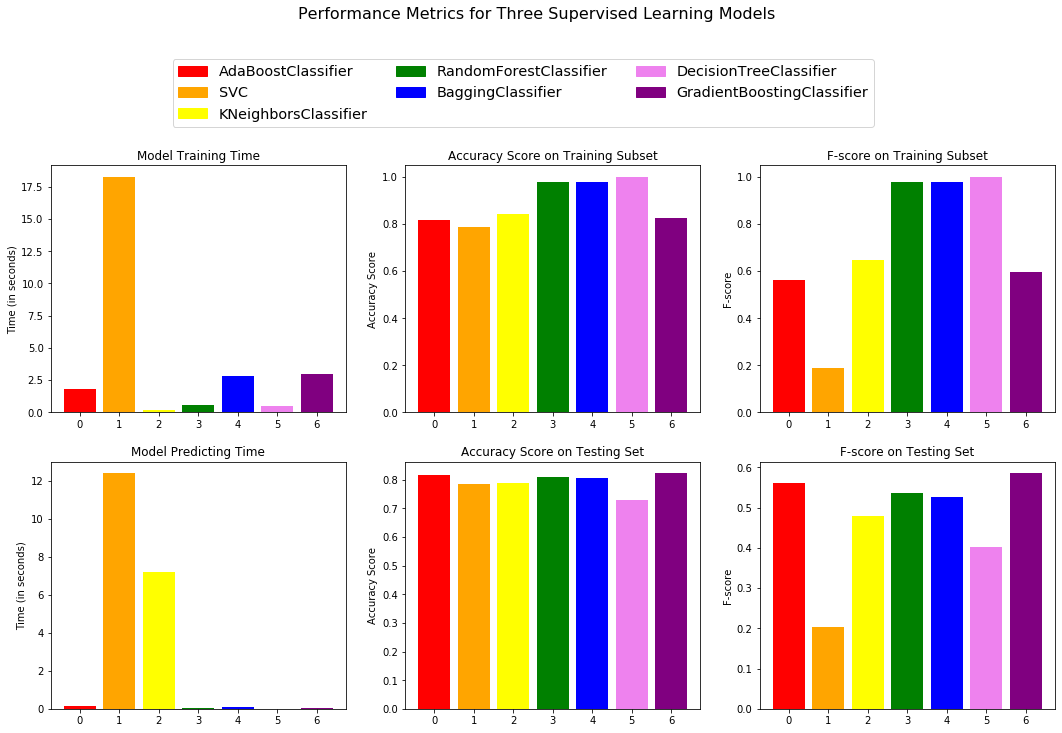

In [171]:
fig, ax = plt.subplots(2, 3, figsize = (18,10))
colors = ['red','orange','yellow','green','blue','violet','purple']
ax[0,0].bar(range(len(results)), tt, align='center',color = colors)
ax[0,1].bar(range(len(results)), atr, align='center',color = colors)
ax[0,2].bar(range(len(results)), ftr, align='center',color = colors)
ax[1,0].bar(range(len(results)), pt, align='center',color = colors)
ax[1,1].bar(range(len(results)), at, align='center',color = colors)
ax[1,2].bar(range(len(results)), ft, align='center',color = colors)

 # Add titles
ax[0, 0].set_title("Model Training Time")
ax[0, 1].set_title("Accuracy Score on Training Subset")
ax[0, 2].set_title("F-score on Training Subset")
ax[1, 0].set_title("Model Predicting Time")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[1, 2].set_title("F-score on Testing Set")

# Add unique y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Accuracy Score")
ax[0, 2].set_ylabel("F-score")
ax[1, 0].set_ylabel("Time (in seconds)")
ax[1, 1].set_ylabel("Accuracy Score")
ax[1, 2].set_ylabel("F-score")

 # Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.63), loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')

plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
plt.show()

<font color="red"> # fill this in 
Based on the above graph, we can see that the best model for this project is .......because......

# 6. Model training/validation

This contains a breakdown of how your model was trained and evaluated.


# 7. Results

Here you show the results that you obtain using your model on the training data. If you have multiple variations or approaches, this is where you compare them.


# 8. Final predictions

This is the section where you perform your final predictions on the test set using the model that you have trained in the previous section.


# Todo list
+ runtime vs 的图
+ limit 和每月bill的差
+ 每月pay和bill的差
+ auto tune vs